# Data Loading and Preprocessing

In [1]:
from autoencoder import *
import glob
from IPython.display import Audio

2022-12-04 01:18:13.728725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-04 01:18:13.731710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 01:18:13.731718: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
def get_audio(filepaths, num_vectors=100, sr=22050):
    """
    Currently really slow: approximately 34 files read per second, but there are
    over 100,000 files
    """
    zipped_fname = f"raw_audio_{sr}.zip"
    audio_fname = f"raw_audio_{sr}.npy"
    audio = []
    np.random.shuffle(filepaths)
    start = time.time()
    random_indices = [i for i in range(num_vectors)]
    np.random.shuffle(random_indices)
    '''with ProcessPoolExecutor(max_workers=3) as exe:
        completed = exe.map(get_single_file, filepaths[:num_vectors], repeat(sr), chunksize=40)
        for item in completed:
            if item.shape[0] == sr:
                audio.append(item)'''
    if os.path.isfile(zipped_fname):
        with zipfile.ZipFile(zipped_fname, "r") as zip_ref:
            with zip_ref.open(audio_fname) as unzipped:
                audio = np.load(unzipped)
                print(time.time() - start)
                return audio[random_indices]
    for i, path in enumerate(filepaths):
        if i >= num_vectors:
            break
        X, sample_rate = librosa.load(path, sr=sr)
        if X.shape[0] != sample_rate:
            X = librosa.util.fix_length(X, size=sr)
        audio.append(X)
    print(time.time() - start)
    with zipfile.ZipFile(zipped_fname, "w") as zip_ref:
        np.save(audio_fname.replace(".npy", ""), audio)
        zip_ref.write(audio_fname)
    return np.array(audio, dtype=np.float32)[random_indices]

In [17]:
sr = 22050
filepaths = get_all_files("wav")
audio = get_audio(filepaths, num_vectors=3000, sr=sr)

63.827716588974


In [18]:
X_train, X_test = conv_data(audio, sr)

2.8285751342773438


# Audio Visualization

In [20]:
Audio(audio[0], rate=sr)

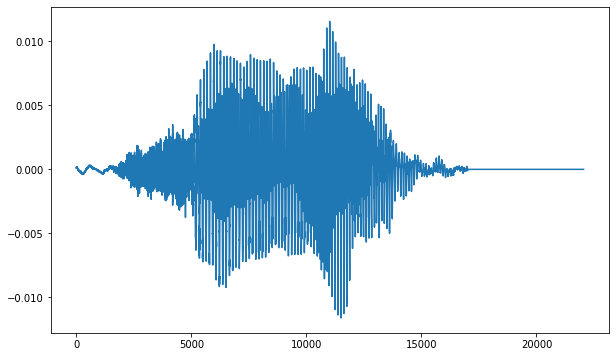

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(audio[0])

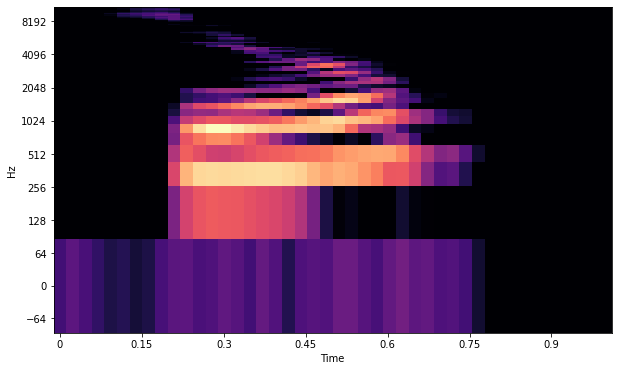

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
index = np.random.randint(0, len(audio))
mel = librosa.feature.melspectrogram(y=audio[0], sr=sr, n_mels=64)
mel_to_db = librosa.amplitude_to_db(mel, ref=np.max)
librosa.display.specshow(mel_to_db, x_axis="time", y_axis="log", ax=ax)
reshaped = mel.reshape(*mel.shape, 1)
fig.savefig("asdf.png")

# Plot Random Melspectrograms

In [23]:
X_test.shape

(900, 64, 44, 1)

# Get Convolutional Model

In [25]:
def get_conv_model(input_shape, latent_units = 50):
    Input = tf.keras.Input(shape=input_shape)
    #encoder = Sequential()
    x = layers.Conv2D(64, (3, 3), input_shape=input_shape, activation="leaky_relu", padding="same")(Input)
    x = layers.MaxPool2D((2, 2), padding="same")(x)
    #print(encoder.summary())
    #latent = encoder(Input)
    #decoder = Sequential()
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="leaky_relu", padding="same")(x)
    x = layers.Conv2D(1, (1, 1), activation="linear")(x)
    print(x.shape)
    #print(decoder.summary())

    model = Model(inputs=Input, outputs=x)
    print(model.summary())
    model.compile(optimizer="adam", loss="MSE")
    return model

In [26]:
latent = 1000
print(X_train.shape[1:])
model = get_conv_model(X_train.shape[1:], latent)

(64, 44, 1)
(None, 64, 44, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 44, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 44, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 44, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 44, 1)         65        
                                                                 
Total params: 37,633
Trainable 

2022-12-04 01:22:20.054789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 01:22:20.054810: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 01:22:20.054830: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jonaz-17Z90N-R-AAC8U1): /proc/driver/nvidia/version does not exist
2022-12-04 01:22:20.055026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model_name = f"mel_{sr}_{latent}_{model.loss}"
checkpoint_callback = get_checkpoint(model_name)
model.fit(X_train, X_train, epochs=20, batch_size=48, shuffle=True, callbacks=[checkpoint_callback], validation_split=0.1)

Epoch 1/20
39/40 [============================>.] - ETA: 0s - loss: 1573.9497

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 101ms/step - loss: 1559.6340 - val_loss: 70.6322
Epoch 2/20
39/40 [============================>.] - ETA: 0s - loss: 66.1786

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 93ms/step - loss: 65.9890 - val_loss: 47.2861
Epoch 3/20
39/40 [============================>.] - ETA: 0s - loss: 37.0997

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 94ms/step - loss: 37.0076 - val_loss: 27.7275
Epoch 4/20
39/40 [============================>.] - ETA: 0s - loss: 19.5647

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 101ms/step - loss: 19.4931 - val_loss: 12.8089
Epoch 5/20
39/40 [============================>.] - ETA: 0s - loss: 9.9995 

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 106ms/step - loss: 9.9976 - val_loss: 9.1703
Epoch 6/20
39/40 [============================>.] - ETA: 0s - loss: 8.6707

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 99ms/step - loss: 8.6600 - val_loss: 8.7788
Epoch 7/20
39/40 [============================>.] - ETA: 0s - loss: 8.3603

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 107ms/step - loss: 8.3543 - val_loss: 8.4924
Epoch 8/20
39/40 [============================>.] - ETA: 0s - loss: 8.0674

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 103ms/step - loss: 8.0720 - val_loss: 8.1719
Epoch 9/20
39/40 [============================>.] - ETA: 0s - loss: 7.7184

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 108ms/step - loss: 7.7122 - val_loss: 7.7791
Epoch 10/20
39/40 [============================>.] - ETA: 0s - loss: 7.4128

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 103ms/step - loss: 7.4047 - val_loss: 7.4959
Epoch 11/20
39/40 [============================>.] - ETA: 0s - loss: 7.1260

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 118ms/step - loss: 7.1337 - val_loss: 7.2103
Epoch 12/20
39/40 [============================>.] - ETA: 0s - loss: 6.8481

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 113ms/step - loss: 6.8641 - val_loss: 6.9224
Epoch 13/20
39/40 [============================>.] - ETA: 0s - loss: 6.6082

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 103ms/step - loss: 6.5989 - val_loss: 6.6702
Epoch 14/20
39/40 [============================>.] - ETA: 0s - loss: 6.3862

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 101ms/step - loss: 6.3764 - val_loss: 6.4430
Epoch 15/20
39/40 [============================>.] - ETA: 0s - loss: 6.1818

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 5s 117ms/step - loss: 6.1764 - val_loss: 6.2386
Epoch 16/20
39/40 [============================>.] - ETA: 0s - loss: 5.9749

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 110ms/step - loss: 5.9899 - val_loss: 6.0433
Epoch 17/20
39/40 [============================>.] - ETA: 0s - loss: 5.8216

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 100ms/step - loss: 5.8127 - val_loss: 5.8552
Epoch 18/20
39/40 [============================>.] - ETA: 0s - loss: 5.6400

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 109ms/step - loss: 5.6432 - val_loss: 5.6825
Epoch 19/20
39/40 [============================>.] - ETA: 0s - loss: 5.4945

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 113ms/step - loss: 5.4823 - val_loss: 5.5148
Epoch 20/20
40/40 [==============================] - ETA: 0s - loss: 5.3310

INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


INFO:tensorflow:Assets written to: models/mel_22050_1000_MSE/assets


40/40 [==============================] - 4s 108ms/step - loss: 5.3310 - val_loss: 5.3537


# Predict and Convert to Audio

In [28]:
pred = model.predict(X_test)

29/29 [==============================] - 1s 22ms/step


# Compare Spectrograms of Predicted vs. Actual

In [29]:
reshaped_pred = pred.reshape(pred.shape[:-1])
reshaped_actual = X_test.reshape(X_test.shape[:-1])

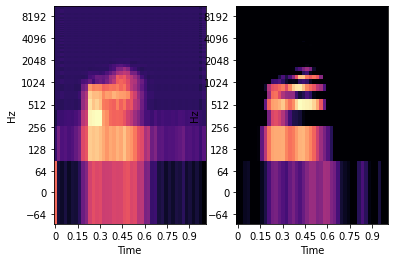

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)
librosa.display.specshow(reshaped_pred[0], x_axis="time", y_axis="log", ax=ax1)
librosa.display.specshow(reshaped_actual[0], x_axis="time", y_axis="log", ax=ax2)
fig.savefig("asdf.png")

In [32]:
amp_pred = librosa.db_to_amplitude(reshaped_pred[0])
amp_actual = librosa.db_to_amplitude(reshaped_actual[0])
audio_pred = librosa.feature.inverse.mel_to_audio(amp_pred)
audio_actual = librosa.feature.inverse_mel_to_audio(amp_actual)

AttributeError: module 'librosa.feature' has no attribute 'inverse_mel_to_audio'